# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [2]:
!pip install labelme tensorflow  opencv-python matplotlib albumentations

### 1.2 Collect Images Using OpenCV

In [3]:
import os
import time
import uuid
import cv2

In [10]:
IMAGES_PATH = os.path.join('plant','images')
number_images = 60

In [12]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [13]:
!labelme

2024-05-14 16:19:53,607 [INFO   ] __init__:get_config:67- Loading config file from: /Users/sadiakhanrupa/.labelmerc
^C


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [14]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [15]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [16]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 2.3 Load Image into TF Data Pipeline

In [18]:
images = tf.data.Dataset.list_files('plant/images/*.jpg')

In [19]:
images.as_numpy_iterator().next()

b'plant/images/f10a8c8c-11fc-11ef-baf4-9a06e4b320ab.jpg'

In [20]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [21]:
images = images.map(load_image)

In [22]:
images.as_numpy_iterator().next()

array([[[251, 253, 252],
        [251, 253, 252],
        [251, 253, 252],
        ...,
        [229, 231, 218],
        [237, 239, 226],
        [235, 237, 224]],

       [[251, 253, 252],
        [251, 253, 252],
        [251, 253, 252],
        ...,
        [232, 234, 221],
        [237, 239, 226],
        [236, 238, 225]],

       [[251, 253, 252],
        [251, 253, 252],
        [251, 253, 252],
        ...,
        [240, 242, 231],
        [242, 244, 233],
        [241, 243, 232]],

       ...,

       [[144, 142, 129],
        [142, 140, 127],
        [141, 139, 126],
        ...,
        [ 64,  60,  59],
        [ 65,  61,  60],
        [ 66,  62,  61]],

       [[144, 142, 129],
        [142, 140, 127],
        [142, 140, 127],
        ...,
        [ 64,  60,  59],
        [ 65,  61,  60],
        [ 65,  61,  60]],

       [[143, 141, 128],
        [143, 141, 128],
        [143, 141, 128],
        ...,
        [ 64,  60,  59],
        [ 65,  61,  60],
        [ 65,  61,  60]]

In [23]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [24]:
image_generator = images.batch(4).as_numpy_iterator()

In [25]:
plot_images = image_generator.next()

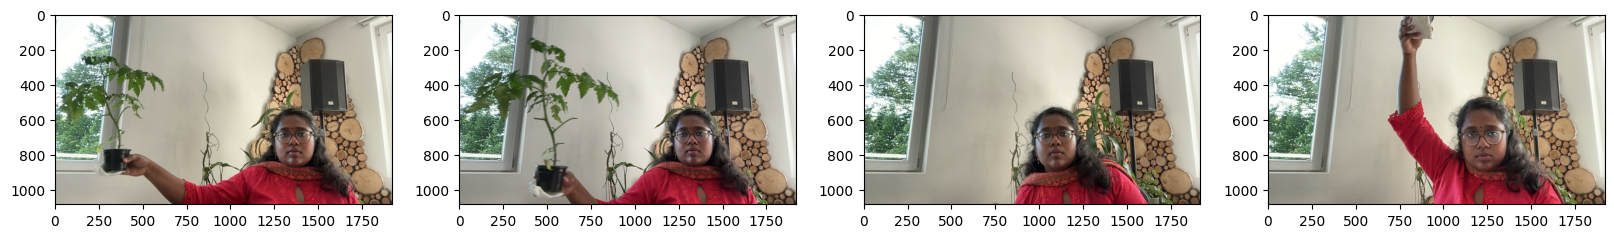

In [26]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [27]:
60*.7 # 42 to train #move data manually

42.0

In [28]:
60*.15 # 9 and 9 to test and val

9.0

### 3.2 Move the Matching Labels

In [220]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('plant', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('plant','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('plant',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [221]:
import albumentations as alb

In [222]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [223]:
img = cv2.imread(os.path.join('plant','test', 'images','eda8a13c-11fc-11ef-baf4-9a06e4b320ab.jpg'))

In [224]:
with open(os.path.join('plant', 'test', 'labels', 'eda8a13c-11fc-11ef-baf4-9a06e4b320ab.json'), 'r') as f:
    label = json.load(f)

In [225]:
label['shapes'][0]['points']

[[586.1904761904761, 470.95238095238096],
 [1135.3968253968253, 999.5238095238094]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [226]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [227]:
coords

[586.1904761904761, 470.95238095238096, 1135.3968253968253, 999.5238095238094]

In [228]:
coords = list(np.divide(coords, [640,480,640,480]))

In [229]:
coords

[0.915922619047619, 0.9811507936507937, 1.7740575396825395, 2.0823412698412698]

### 4.4 Apply Augmentations and View Results

In [230]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['plant'])

ValueError: Expected x_max for bbox [0.915922619047619, 0.9811507936507937, 1.7740575396825395, 2.0823412698412698, 'plant'] to be in the range [0.0, 1.0], got 1.7740575396825395.

In [231]:
augmented['bboxes'][0][2:]

IndexError: list index out of range

In [109]:
augmented['bboxes']

[]

In [110]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

IndexError: list index out of range

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [232]:
# Ensure these directories exist
os.makedirs('aug_data_plant/train/images', exist_ok=True)
os.makedirs('aug_data_plant/train/labels', exist_ok=True)
os.makedirs('aug_data_plant/test/images', exist_ok=True)
os.makedirs('aug_data_plant/test/labels', exist_ok=True)
os.makedirs('aug_data_plant/val/images', exist_ok=True)
os.makedirs('aug_data_plant/val/labels', exist_ok=True)

In [233]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('plant', partition, 'images')):
        img = cv2.imread(os.path.join('plant', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('plant', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['plant'])
                cv2.imwrite(os.path.join('aug_data_plant', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data_plant', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

Expected x_min for bbox [1.2209821428571428, 0.018849206349206327, 1.8608630952380953, 0.2569444444444444, 'plant'] to be in the range [0.0, 1.0], got 1.2209821428571428.
Expected x_max for bbox [0.057787698412698305, 0.3296957671957672, 1.096974206349206, 1.338293650793651, 'plant'] to be in the range [0.0, 1.0], got 1.096974206349206.
Expected x_max for bbox [0.529017857142857, 0.48842592592592593, 1.5830853174603174, 1.814484126984127, 'plant'] to be in the range [0.0, 1.0], got 1.5830853174603174.
Expected y_max for bbox [0.02554563492063481, 0.5281084656084656, 0.9382440476190474, 1.5201719576719577, 'plant'] to be in the range [0.0, 1.0], got 1.5201719576719577.
Expected y_min for bbox [0.8861607142857142, 1.3812830687830688, 1.3772321428571428, 1.9599867724867726, 'plant'] to be in the range [0.0, 1.0], got 1.3812830687830688.
Expected y_min for bbox [0.7720734126984126, 1.8938492063492063, 1.223293529810298, 2.247916666666667, 'plant'] to be in the range [0.0, 1.0], got 1.89384

### 5.2 Load Augmented Images to Tensorflow Dataset

In [234]:
train_images = tf.data.Dataset.list_files('aug_data_plant/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [235]:
test_images = tf.data.Dataset.list_files('aug_data_plant/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: aug_data_plant/test/images/*.jpg'

In [56]:
val_images = tf.data.Dataset.list_files('aug_data_plant/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [57]:
train_images.as_numpy_iterator().next()

array([[[0.02261029, 0.02653186, 0.00692402],
        [0.01979167, 0.02371323, 0.00410539],
        [0.02205882, 0.02598039, 0.00637255],
        ...,
        [0.02395833, 0.0278799 , 0.00827206],
        [0.09166667, 0.09558824, 0.07205883],
        [0.15539216, 0.15625   , 0.13517156]],

       [[0.01930147, 0.02322304, 0.0036152 ],
        [0.02352941, 0.02696078, 0.00882353],
        [0.01960784, 0.02352941, 0.00392157],
        ...,
        [0.03345588, 0.03737745, 0.01776961],
        [0.059375  , 0.06329657, 0.04368873],
        [0.15686275, 0.15796569, 0.15079656]],

       [[0.02058824, 0.0245098 , 0.00490196],
        [0.02647059, 0.02647059, 0.01862745],
        [0.02647059, 0.02647059, 0.01862745],
        ...,
        [0.05257353, 0.0564951 , 0.03296569],
        [0.07279412, 0.06887255, 0.04926471],
        [0.11911765, 0.11764706, 0.10557598]],

       ...,

       [[0.03394608, 0.03394608, 0.02610294],
        [0.02401961, 0.02401961, 0.01617647],
        [0.02144608, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [58]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [59]:
train_labels = tf.data.Dataset.list_files('aug_data_plant/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [60]:
test_labels = tf.data.Dataset.list_files('aug_data_plant/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: aug_data_plant/test/labels/*.json'

In [61]:
val_labels = tf.data.Dataset.list_files('aug_data_plant/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [62]:
train_labels.as_numpy_iterator().next()

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [64]:
len(train_images), len(train_labels), len(val_images), len(val_labels)

(660, 660, 300, 300)

### 7.2 Create Final Datasets (Images/Labels)

In [111]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [112]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

NameError: name 'test_images' is not defined

In [113]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [123]:
train.as_numpy_iterator().next()[1]

(array([[0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0]], dtype=uint8),
 array([[0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.1653, 0.851 , 0.9976, 0.9976],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ]], dtype=float16))

### 7.3 View Images and Annotations

In [124]:
data_samples = train.as_numpy_iterator()

In [164]:
res = data_samples.next()

In [126]:
res

(array([[[[0.62352943, 0.6127451 , 0.56715685],
          [0.6220588 , 0.60637254, 0.5632353 ],
          [0.6269608 , 0.6039216 , 0.5632353 ],
          ...,
          [0.78186274, 0.76617646, 0.7205882 ],
          [0.8050858 , 0.7893995 , 0.74626225],
          [0.8047794 , 0.78909314, 0.75085783]],
 
         [[0.6102941 , 0.5998775 , 0.5541054 ],
          [0.6107843 , 0.595098  , 0.55196077],
          [0.6107843 , 0.595098  , 0.55196077],
          ...,
          [0.78523284, 0.76954657, 0.7273897 ],
          [0.79901963, 0.78333336, 0.74718136],
          [0.80557597, 0.7898897 , 0.7545956 ]],
 
         [[0.59656864, 0.5887255 , 0.5416667 ],
          [0.5995098 , 0.5838235 , 0.54068625],
          [0.6       , 0.58431375, 0.5411765 ],
          ...,
          [0.8030025 , 0.7873162 , 0.7520221 ],
          [0.7995711 , 0.7838848 , 0.7485907 ],
          [0.79479164, 0.78302693, 0.7477328 ]],
 
         ...,
 
         [[0.43547794, 0.41979167, 0.37665442],
          [0.44607

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


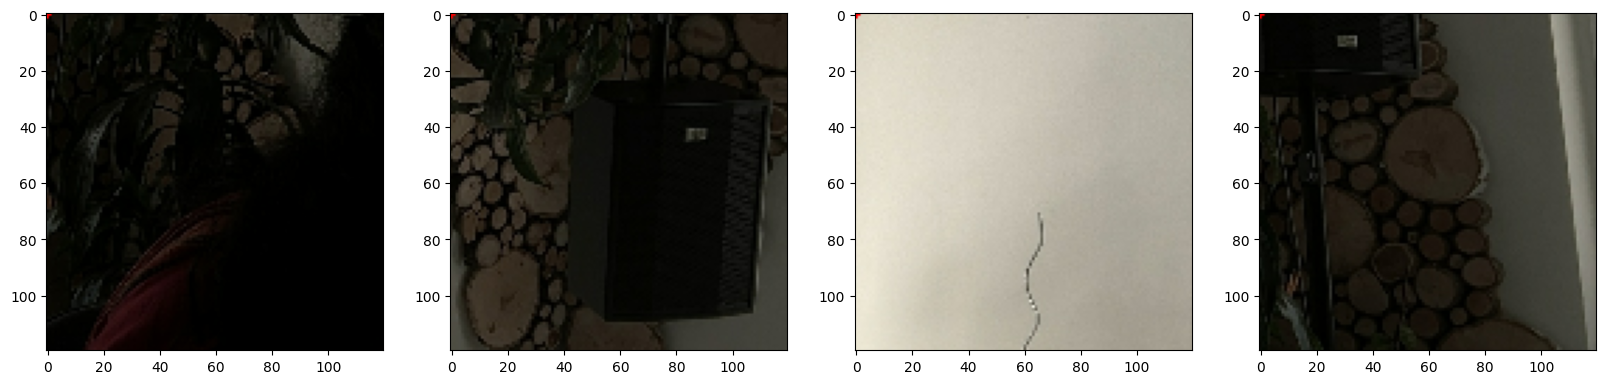

In [194]:
res = data_samples.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx].copy()
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [128]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [129]:
vgg = VGG16(include_top=False)

In [130]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### 8.3 Build instance of Network

In [131]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [132]:
facetracker = build_model()

In [133]:
facetracker.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │      2,049 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 4)         │      8,196 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [201]:
X, y = train.as_numpy_iterator().next()

In [202]:
X.shape

(8, 120, 120, 3)

In [203]:
classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [204]:
classes, coords

(array([[0.6062226 ],
        [0.6752583 ],
        [0.6736685 ],
        [0.6718016 ],
        [0.6136349 ],
        [0.6474244 ],
        [0.61277217],
        [0.6431109 ]], dtype=float32),
 array([[0.4301546 , 0.57393134, 0.6091306 , 0.51469505],
        [0.4403516 , 0.54153544, 0.6552453 , 0.5394157 ],
        [0.5191187 , 0.5691247 , 0.66533506, 0.53666145],
        [0.46196046, 0.62313926, 0.64467615, 0.516264  ],
        [0.464979  , 0.5963254 , 0.62893635, 0.482943  ],
        [0.4949168 , 0.59274197, 0.670806  , 0.5482709 ],
        [0.43935356, 0.5779983 , 0.6623124 , 0.5519567 ],
        [0.44816905, 0.539452  , 0.64257705, 0.49505138]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [205]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [206]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

/Users/sadiakhanrupa/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


### 9.2 Create Localization Loss and Classification Loss

In [207]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [208]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [209]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=7.0088997>

In [210]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8697464>

In [211]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=7.0088997>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [213]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [214]:
model = FaceTracker(facetracker)

In [215]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [216]:
logdir='logs'

In [218]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [219]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10


ValueError: Cannot take the length of shape with unknown rank.

### 10.3 Plot Performance

In [152]:
hist.history

NameError: name 'hist' is not defined

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat = facetracker.predict(test_sample[0])

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
facetracker.save('facetracker.h5')

In [ ]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [ ]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()